In [94]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from tensorflow.keras.datasets import cifar10
from skimage.feature import hog
from sklearn.decomposition import PCA

# 1. Download and load CIFAR-10 dataset
print("Downloading and loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert labels from 2D to 1D array
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [95]:
feature_detector = 'sift'  # 'orb' or 'sift' if available
n_features = 50  # Maximum number of features per image
n_clusters = 100  # Size of visual vocabulary
max_samples = 5000  
# In main():
# n_clusters = 300  # Increased from 100
# n_samples = 20000  # Use 40% of training data
# max_features = 100  # Doubled from 50


In [96]:
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray = cv2.equalizeHist(gray)
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)
    return hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell, 
               cells_per_block=cells_per_block, feature_vector=True)

def extract_features(image, feature_detector='orb', max_features=50):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # gray = cv2.equalizeHist(gray)
    else:
        gray = image
        
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)

    if feature_detector.lower() == 'orb':
        detector = cv2.ORB_create(nfeatures=max_features)
    elif feature_detector.lower() == 'sift':
        try:
            detector = cv2.SIFT_create(nfeatures=max_features)
        except AttributeError:
            print("SIFT not available, falling back to ORB")
            detector = cv2.ORB_create(nfeatures=max_features)

    keypoints, descriptors = detector.detectAndCompute(gray, None)
    if len(keypoints) == 0:
        print("No keypoints detected")
    return keypoints, descriptors


def extract_features_from_dataset(dataset, num_samples=15000, feature_detector='orb', max_features=50):
    all_descriptors = []
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    for i in indices:
        image = dataset[i]
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        
        hog_features = extract_hog_features(image)
        _, descriptors = extract_features(image, feature_detector, max_features)

        if descriptors is not None and descriptors.size > 0:
            descriptors = descriptors.mean(axis=0) 
        else:
            descriptors = np.zeros((128,))

        combined_features = np.hstack([hog_features, descriptors])
        all_descriptors.append(combined_features)
    
    if not all_descriptors:
        raise ValueError("No features could be extracted from the dataset")
        
    return np.vstack(all_descriptors) , indices

In [97]:
print("Extracting features from training set...")
training_features, indices = extract_features_from_dataset(
    x_train, n_samples, feature_detector, max_features
)
pca = PCA(n_components=128)
training_features = pca.fit_transform(training_features)

print(f"Shape: {training_features.shape} feature descriptors.")
print(f"Extracted {training_features.shape[0]} feature descriptors.")

sample_labels = y_train[indices]
from collections import Counter
sample_class_counts = Counter(sample_labels)
print("Class Distribution in Random Sample:")
for class_id, count in sample_class_counts.items():
    print(f"{class_names[class_id]}: {count}")


Extracting features from training set...
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
No keypoints detected
Shape: (20000, 128) feature descriptors.
Extracted 20000 feature descriptors.
Class Distribution in Random Sample:
ship: 2065
dog: 1962
bird: 2003
airplane: 2010
cat: 1949
truck: 2036
frog: 1981
horse: 2018
deer

In [98]:
training_features

array([[-26.16186062, -30.3636459 ,  17.00127084, ...,   0.35444808,
          0.12545782,  -1.43668933],
       [ 80.66575814, -24.37468112,  18.24276105, ...,  -0.68480494,
         -0.22626177,   1.28071368],
       [-87.87625967, -10.70856193,  76.31088843, ...,  -0.09471337,
         -2.89378079,  -0.81580351],
       ...,
       [ 62.17100746,  67.29254753,   7.02981695, ...,   0.70644095,
         -1.17845242,   0.59205918],
       [-61.0606718 , -41.06041459,  20.60090718, ...,   0.46869043,
         -2.70352847,  -1.33347017],
       [ 70.61895347, -36.61233812, -69.16267595, ...,   2.57491177,
          0.69771798,  -0.17613772]])

In [99]:
def create_visual_vocabulary(features, n_clusters=100):
    print(f"Creating vocabulary with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(features)
    return kmeans

print("Creating visual vocabulary...")
kmeans = create_visual_vocabulary(training_features, n_clusters)
print("Visual vocabulary created.")

Creating visual vocabulary...
Creating vocabulary with 100 clusters...
Visual vocabulary created.


In [ ]:

# 5. Generate histogram of visual words for an image
def create_histogram(descriptors, kmeans, n_clusters=100):
    if descriptors is None or descriptors.shape[0] == 0:
        return np.zeros(n_clusters)
    
    # Assign each descriptor to a cluster
    cluster_indices = kmeans.predict(descriptors)
    
    # Create histogram
    histogram = np.zeros(n_clusters)
    for index in cluster_indices:
        histogram[index] += 1
        
    # Normalize histogram
    if np.sum(histogram) > 0:
        histogram = histogram / np.sum(histogram)
        
    return histogram

def create_histograms_for_dataset(dataset, kmeans, n_clusters=100, feature_detector='orb', max_features=50):
    histograms = []
    
    for i in range(len(dataset)):
        if i % 1000 == 0:
            print(f"Processing image {i}/{len(dataset)}...")
            
        image = dataset[i]
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
            
        
        _, query_descriptors = extract_features(image, feature_detector, max_features)
        hog_features = extract_hog_features(image)

        # Handle case where no descriptors were found
        if query_descriptors is None or query_descriptors.size == 0:
            query_descriptors = np.zeros((1, 128))  # Default zero vector

        # Combine HOG and PCA-transformed SIFT/ORB descriptors
        descriptors = np.hstack([hog_features, query_descriptors.flatten()])
        
        descriptors = pca.transform(descriptors.reshape(-1,1))
        histogram = create_histogram(descriptors, kmeans, n_clusters)
        histograms.append(histogram)
            
    return np.array(histograms)

print("Creating histograms for test set...")
test_histograms = create_histograms_for_dataset(
    x_test, kmeans, n_clusters, feature_detector, max_features
)
print("Test histograms created.")


Creating histograms for test set...
Processing image 0/10000...


ValueError: X has 1604 features, but PCA is expecting 452 features as input.

In [ ]:

def retrieve_similar_images(query_image, test_histograms, kmeans, top_n=5, 
                           feature_detector='orb', n_clusters=100, max_features=50,
                           query_index=None):
    # Ensure query image is uint8
    if query_image.dtype != np.uint8:
        query_image = (query_image * 255).astype(np.uint8)
        
    _, query_descriptors = extract_features(query_image, feature_detector, max_features)
    hog_features = extract_hog_features(query_image)

    # Handle case where no descriptors were found
    if query_descriptors is None or query_descriptors.size == 0:
        query_descriptors = np.zeros((1, 128))  # Default zero vector

    # Combine HOG and PCA-transformed SIFT/ORB descriptors
    query_features = np.hstack([hog_features, query_descriptors.flatten()])

    query_descriptors = pca.transform(query_features)
    # Create query histogram
    query_histogram = create_histogram(query_descriptors, kmeans, n_clusters)
    metric = 'chi-square'
    from scipy.spatial.distance import cdist
    if metric == 'chi-square':
        distances = 0.5 * np.sum(((query_histogram - test_histograms) ** 2) / 
                                  (query_histogram + test_histograms + 1e-10), axis=1)
    elif metric == 'euclidean':
        distances = np.linalg.norm(test_histograms - query_histogram, axis=1)
    elif metric == 'manhattan':
        distances = np.sum(np.abs(test_histograms - query_histogram), axis=1)
    else:  # Default to cosine similarity
        from sklearn.metrics.pairwise import cosine_similarity
        distances = 1 - cosine_similarity(query_histogram, test_histograms).flatten()
    
    # Get sorted indices
    sorted_indices = np.argsort(distances)  # Lower distance = more similar
    
    
    # Exclude query index if provided
    if query_index is not None:
        # Create mask to filter out query index
        mask = sorted_indices != query_index
        sorted_indices = sorted_indices[mask]
    
    # Select top_n results
    most_similar_indices = sorted_indices[:top_n]
    
    return most_similar_indices, distances[most_similar_indices]

# 8. Display query image and retrieved images
def display_retrieved_images(query_image, query_label, retrieved_indices, test_images, test_labels, similarities):
    plt.figure(figsize=(15, 8))

    plt.subplot(3, 3, 1)
    plt.imshow(query_image)
    plt.title(f"Query: {class_names[query_label]}")
    plt.axis('off')
    
    for i, idx in enumerate(retrieved_indices):
        plt.subplot(3, 3, i+4)
        plt.imshow(test_images[idx])
        plt.title(f"{class_names[test_labels[idx]]}, Sim: {similarities[i]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()




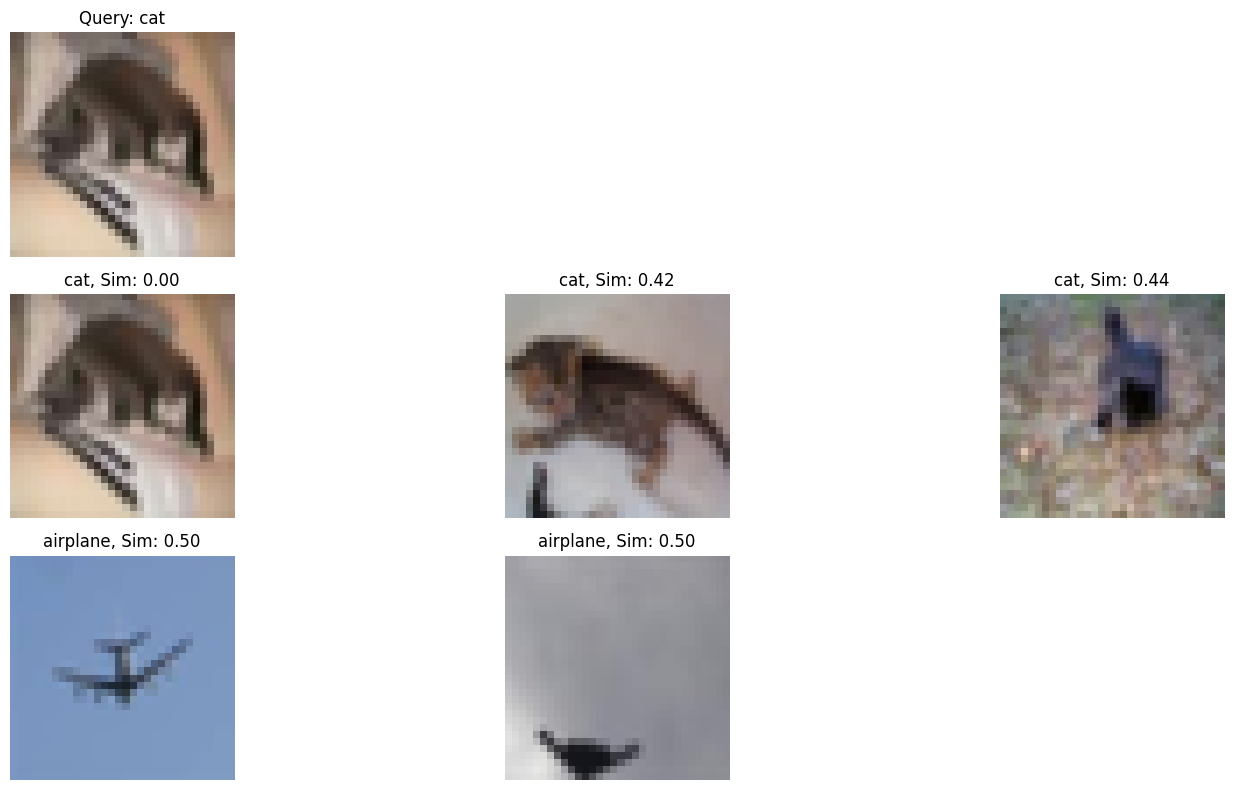

In [ ]:

query_idx = np.random.randint(0, len(x_test))
query_image = x_test[query_idx]
query_label = y_test[query_idx]

retrieved_indices, similarities = retrieve_similar_images(
    query_image, test_histograms, kmeans,
    top_n=5, feature_detector=feature_detector, 
    n_clusters=n_clusters, max_features=max_features
)

display_retrieved_images(
    query_image, query_label, retrieved_indices, 
    x_test, y_test, similarities
)

In [ ]:
from sklearn.metrics import average_precision_score
from collections import defaultdict

# Add these functions after the display_retrieved_images function

def calculate_retrieval_metrics(query_label, retrieved_indices, test_labels, top_k=5):
    """
    Calculate precision@k, recall@k, and average precision for a single query
    """
    # Get ground truth relevance
    relevant = (test_labels == query_label)
    relevant[retrieved_indices[0]] = False  # Exclude query image itself
    
    # Get retrieved results
    retrieved = retrieved_indices[:top_k]
    
    # Calculate metrics
    hits = np.sum(relevant[retrieved])
    
    precision = hits / top_k
    recall = hits / np.sum(relevant)
    
    # Calculate average precision
    y_true = relevant[retrieved_indices].astype(int)
    y_score = np.arange(len(retrieved_indices), 0, -1)  # Simulate confidence scores
    ap = average_precision_score(y_true, y_score) if sum(y_true) > 0 else 0
    
    return precision, recall, ap

def evaluate_retrieval_performance(test_images, test_labels, test_histograms, kmeans, 
                                  num_queries=100, top_k=5, feature_detector='orb'):
    """
    Evaluate retrieval performance on multiple queries
    """
    results = defaultdict(list)
    
    # Select random queries
    query_indices = np.random.choice(len(test_images), num_queries, replace=False)
    
    for i, query_idx in enumerate(query_indices):
        query_image = test_images[query_idx]
        query_label = test_labels[query_idx]
        
        # Retrieve similar images (excluding query itself)
        retrieved_indices, _ = retrieve_similar_images(
            query_image, test_histograms, kmeans,
            top_n=top_k*2,  # Retrieve more to calculate AP
            feature_detector=feature_detector,
            query_index=query_idx
        )
        
        # Calculate metrics
        precision, recall, ap = calculate_retrieval_metrics(
            query_label, retrieved_indices, test_labels, top_k
        )
        
        # Store results
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['ap'].append(ap)
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{num_queries} queries...")
    
    # Calculate mean metrics
    mean_metrics = {
        'precision@k': np.mean(results['precision']),
        'recall@k': np.mean(results['recall']),
        'map': np.mean(results['ap']),
        'class_distribution': {
            cls: sum(test_labels[query_indices] == cls) 
            for cls in np.unique(test_labels)
        }
    }
    
    return mean_metrics


In [ ]:
evaluation_params = {
    'num_queries': 100,
    'top_k': 5,       
}

# 7. Evaluate retrieval performance
print("\nEvaluating retrieval performance...")
metrics = evaluate_retrieval_performance(
    x_test, y_test, test_histograms, kmeans,
    **evaluation_params
)

# Print metrics
print("\nRetrieval Metrics:")
print(f"Mean Average Precision (mAP): {metrics['map']:.4f}")
print(f"Precision@{evaluation_params['top_k']}: {metrics['precision@k']:.4f}")
print(f"Recall@{evaluation_params['top_k']}: {metrics['recall@k']:.4f}")

# Print class distribution of evaluated queries
print("\nClass distribution of evaluated queries:")
for cls, count in metrics['class_distribution'].items():
    print(f"{class_names[cls]:>12}: {count} queries")


Evaluating retrieval performance...
Processed 10/100 queries...
Processed 20/100 queries...
Processed 30/100 queries...
Processed 40/100 queries...
Processed 50/100 queries...
Processed 60/100 queries...
Processed 70/100 queries...
Processed 80/100 queries...
Processed 90/100 queries...
Processed 100/100 queries...

Retrieval Metrics:
Mean Average Precision (mAP): 0.1068
Precision@5: 0.0800
Recall@5: 0.0004

Class distribution of evaluated queries:
    airplane: 10 queries
  automobile: 10 queries
        bird: 11 queries
         cat: 12 queries
        deer: 9 queries
         dog: 11 queries
        frog: 10 queries
       horse: 11 queries
        ship: 10 queries
       truck: 6 queries
